# Домашнее задание 7: Metric Learning на датасете CARS196

Задания:
1. **Метрики оценки** (1 балл): Реализация Precision@k, Recall@k, mAP 
2. **Аугментации для обучения** (1 балл): Добавление аугментаций данных
3. **Обучение модели с triplet loss** (2 балла): 
- Использование другого backbone (не ResNet50) и 
- triplet loss
- Рассчитать метрики из п.1
4. **Анализ ошибок с GradCAM** (1 балл): Визуализация и анализ ошибок модели

> Для формирования предсказаний на тестовой выборке вы не должны предсказывать напрямую класс объекта (не используем метод прямой классификации). Пример формирования предсказаний можно найти в ноутбуке: metric_learning.ipynb блок Faiss

## Описание датасета

CARS196 - это датасет для задач метрического обучения, содержащий изображения автомобилей 196 различных классов. В задаче метрического обучения цель - не прямая классификация, а создание эмбеддингов, где схожие объекты находятся близко в пространстве признаков.

Теперь используем timm с EfficientNet-B0!

После установки с conda

PyTorch 2.9.0 + CUDA 13.0 полностью совместимы с timm.

[arxiv](https://arxiv.org/pdf/1905.11946)

выберем не очень производительную

![image.png](timm.png)

MBConv (Mobile Inverted Bottleneck Convolution) — это специализированный тип блока нейронной сети, впервые представленный в архитектуре MobileNetV2 и позднее применённый в эффективных архитектурах вроде EfficientNet. Он был разработан для повышения вычислительной эффективности и сохранения высокой точности при ограниченных ресурсах


```py
timm.create_model() 
  → скачивает модель через huggingface_hub
    → пытается показать прогресс-бар
      → ищет контекст Jupyter (shell_parent)
        → НЕ НАХОДИТ → LookupError
          → БЛОКИРУЕТ загрузку (исключение не обработано)

После установки флага:

os.environ['HF_HUB_DISABLE_PROGRESS_BARS'] = '1'
  → Hugging Face Hub не создает прогресс-бар
    → НЕТ обращения к shell_parent
      → Загрузка проходит без ошибок
```


## Импорты

In [7]:
import os  # Нужно установить её до импорта библиотеки
os.environ['HF_HUB_DISABLE_PROGRESS_BARS'] = '1'  # Отключить прогресс-бары Hugging Face

# Импорт библиотек
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import timm  # Добавлен timm для EfficientNet

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import cv2
import os
import random
import scipy.io
from tqdm import tqdm

# Для разделения данных
from sklearn.model_selection import train_test_split

# Для GradCAM
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Устанавливаем random seed для воспроизводимости
def seed_everywhere(seed):
    """Функция для фиксации seed для воспроизводимости результатов"""
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    print(f"Установлен seed: {seed}")

seed = 52
seed_everywhere(seed)


Установлен seed: 52


In [8]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"timm version: {timm.__version__}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Используемое устройство: cuda
PyTorch version: 2.9.0+cu130
Torchvision version: 0.24.0+cu130
timm version: 1.0.20
GPU: NVIDIA GeForce RTX 5060
GPU memory: 8.0 GB


## Загрузка и подготовка данных

Сначала загружаем метаданные датасета CARS196 и создаем маппинги для работы с классами.

Разделяем обучающую выборку на train (80%) и validation (20%) с сохранением пропорций классов

In [9]:
# Загрузка метаданных
mat_train = scipy.io.loadmat('../devkit/cars_train_annos.mat')
cars_meta = scipy.io.loadmat('../devkit/cars_meta.mat')

# Создание маппингов для обучающей выборки
fname_to_class = {fname:cl-1 for fname, cl in \
                          zip([i[0] for i in \
                            mat_train['annotations'][0]['fname']], 
                              [i[0][0] for i in mat_train['annotations'][0]['class']])}

id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

print(f"Количество классов: {len(id_to_car)}")
print(f"Количество изображений: {len(fname_to_class)}")
print(f"Пример классов: {list(id_to_car.values())[:5]}")

Количество классов: 196
Количество изображений: 8144
Пример классов: [np.str_('AM General Hummer SUV 2000'), np.str_('Acura RL Sedan 2012'), np.str_('Acura TL Sedan 2012'), np.str_('Acura TL Type-S 2008'), np.str_('Acura TSX Sedan 2012')]


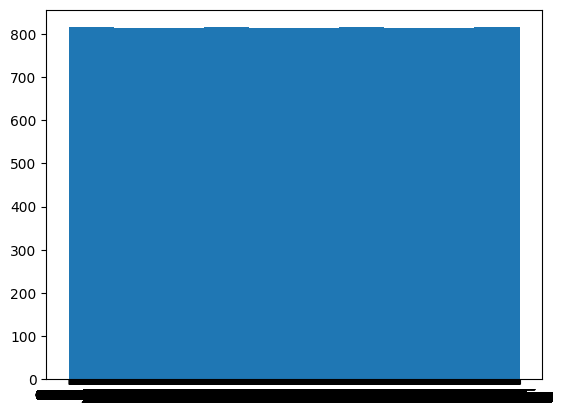

In [10]:
plt.hist(fname_to_class)
plt.show()

[size=(224, 224)](https://huggingface.co/timm/efficientnet_b0.ra_in1k)

- Нужен ли ToPIL перед Resize?

## Метрики оценки

Реализуйте следующие метрики для оценки качества metric learning:
- Precision@k
- Recall@k  
- Mean Average Precision (mAP)

In [11]:
def precision_at_k(embeddings, labels, k=1):
    """
    Вычисляет Precision@k для embeddings
    Доля объектов среди k ближайших соседей, 
    которые принадлежат к тому же классу, что и запрос
    """
    # 1. Матрица расстояний между всеми парами embeddings
    # 2. Для каждого образца найти k ближайших соседей
    # 3. Сколько из них имеют тот же класс
    # 4. Усреднить по всем образцам
    
    n_samples = embeddings.shape[0]
    correct_predictions = 0
    
    # Матрица расстояний (евклидово расстояние)
    distances = np.linalg.norm(embeddings[:, np.newaxis] - embeddings[np.newaxis, :], axis=2)
    
    for i in range(n_samples):
        # Исключаем сам элемент (расстояние до себя = 0)
        dist_row = distances[i]
        # Находим индексы k ближайших соседей (исключая сам элемент)
        nearest_indices = np.argsort(dist_row)[1:k+1]  # [1:k+1] исключает сам элемент
        
        # Проверяем, сколько из k ближайших соседей имеют тот же класс
        same_class_neighbors = np.sum(labels[nearest_indices] == labels[i])
        correct_predictions += same_class_neighbors
    
    precision = correct_predictions / (n_samples * k)
    return precision



In [12]:
def recall_at_k(embeddings, labels, k=1):
    """
    Вычисляет Recall@k для embeddings
    
    Доля всех объектов того же класса из всей тестовой выборки, 
    которые были найдены среди k ближайших соседей
    """

    # 1. Матрица расстояний между всеми парами embeddings
    # 2. Для каждого образца найти k ближайших соседей
    # 3. Сколько из них имеют тот же класс
    # 4. Усреднить по всем образцам
    
    n_samples = embeddings.shape[0]
    total_recall = 0
    
    # Вычисляем матрицу расстояний
    distances = np.linalg.norm(embeddings[:, np.newaxis] - embeddings[np.newaxis, :], axis=2)
    
    for i in range(n_samples):
        # Находим все объекты того же класса (исключая сам элемент)
        same_class_mask = (labels == labels[i]) & (np.arange(n_samples) != i)
        total_same_class = np.sum(same_class_mask)
        
        if total_same_class == 0:
            continue
            
        # Находим k ближайших соседей (исключая сам элемент)
        dist_row = distances[i]
        nearest_indices = np.argsort(dist_row)[1:k+1]
        
        # Считаем, сколько из k ближайших соседей принадлежат тому же классу
        retrieved_same_class = np.sum(labels[nearest_indices] == labels[i])
        
        # Recall для данного объекта
        recall_i = retrieved_same_class / total_same_class
        total_recall += recall_i
    
    # Считаем количество объектов, у которых есть хотя бы один объект того же класса
    valid_samples = 0
    for i in range(n_samples):
        same_class_count = np.sum((labels == labels[i]) & (np.arange(n_samples) != i))
        if same_class_count > 0:
            valid_samples += 1
    
    if valid_samples == 0:
        return 0
    
    return total_recall / valid_samples



In [13]:

def mean_average_precision(embeddings, labels):
    """
    Вычисляет Mean Average Precision (mAP) для embeddings
    """

    # 1. Вычислить для каждого образца вычислите AP (Average Precision)
    # 2. AP = среднее значение precision при каждом релевантном результате
    # 3. mAP = среднее значение AP по всем образцам
    
    n_samples = embeddings.shape[0]
    total_ap = 0
    valid_queries = 0
    
    # Вычисляем матрицу расстояний
    distances = np.linalg.norm(embeddings[:, np.newaxis] - embeddings[np.newaxis, :], axis=2)
    
    for i in range(n_samples):
        # Находим все объекты того же класса (исключая сам элемент)
        same_class_mask = (labels == labels[i]) & (np.arange(n_samples) != i)
        total_relevant = np.sum(same_class_mask)
        
        if total_relevant == 0:
            continue
            
        valid_queries += 1
        
        # Сортируем все остальные объекты по расстоянию
        dist_row = distances[i]
        sorted_indices = np.argsort(dist_row)[1:]  # Исключаем сам элемент
        
        # Вычисляем Average Precision для данного запроса
        relevant_found = 0
        precision_sum = 0
        
        for rank, idx in enumerate(sorted_indices):
            if labels[idx] == labels[i]:  # Найден релевантный объект
                relevant_found += 1
                precision_at_rank = relevant_found / (rank + 1)
                precision_sum += precision_at_rank
        
        if relevant_found > 0:
            ap = precision_sum / total_relevant
            total_ap += ap
    
    if valid_queries == 0:
        return 0
    
    return total_ap / valid_queries



In [14]:

def mean_average_precision(embeddings, labels):
    """
    Вычисляет Mean Average Precision (mAP) для embeddings
    """

    # 1. Вычислить для каждого образца вычислите AP (Average Precision)
    # 2. AP = среднее значение precision при каждом релевантном результате
    # 3. mAP = среднее значение AP по всем образцам
    
    n_samples = embeddings.shape[0]
    total_ap = 0
    valid_queries = 0
    
    # Вычисляем матрицу расстояний
    distances = np.linalg.norm(embeddings[:, np.newaxis] - embeddings[np.newaxis, :], axis=2)
    
    for i in range(n_samples):
        # Находим все объекты того же класса (исключая сам элемент)
        same_class_mask = (labels == labels[i]) & (np.arange(n_samples) != i)
        total_relevant = np.sum(same_class_mask)
        
        if total_relevant == 0:
            continue
            
        valid_queries += 1
        
        # Сортируем все остальные объекты по расстоянию
        dist_row = distances[i]
        sorted_indices = np.argsort(dist_row)[1:]  # Исключаем сам элемент
        
        # Вычисляем Average Precision для данного запроса
        relevant_found = 0
        precision_sum = 0
        
        for rank, idx in enumerate(sorted_indices):
            if labels[idx] == labels[i]:  # Найден релевантный объект
                relevant_found += 1
                precision_at_rank = relevant_found / (rank + 1)
                precision_sum += precision_at_rank
        
        if relevant_found > 0:
            ap = precision_sum / total_relevant
            total_ap += ap
    
    if valid_queries == 0:
        return 0
    
    return total_ap / valid_queries




### Тестирование метрик на простом примере


In [15]:

def test_metrics():
    # Создаем простой пример для тестирования
    # 4 образца, 2 класса
    test_embeddings = np.array([
        [0, 0],      # образец 0, класс 0
        [0.1, 0.1],  # образец 1, класс 0 (близко к образцу 0)
        [1, 1],      # образец 2, класс 1
        [1.1, 1.1]   # образец 3, класс 1 (близко к образцу 2)
    ])
    test_labels = np.array([0, 0, 1, 1])
    
    p1 = precision_at_k(test_embeddings, test_labels, k=1)
    r1 = recall_at_k(test_embeddings, test_labels, k=1) 
    mAP = mean_average_precision(test_embeddings, test_labels)
    
    print(f"Тест метрик:")
    print(f"Precision@1: {p1:.3f}")
    print(f"Recall@1: {r1:.3f}")
    print(f"mAP: {mAP:.3f}")
    
test_metrics()

Тест метрик:
Precision@1: 1.000
Recall@1: 1.000
mAP: 1.000


Ожидаемо получаем все единицы

## Аугментации для обучения 

In [16]:
# Аугментации для обучения
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.33), ratio=(0.3, 3.3))
])

# Трансформации для валидации
val_transforms_new = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print(f"Train: {len(train_transforms.transforms)} трансформаций")
print(f"Val: {len(val_transforms_new.transforms)} трансформаций")

Train: 10 трансформаций
Val: 3 трансформаций


## Создание списков изображений и меток

In [17]:
ADD_PATH = '../cars_train'

# Создаем списки путей и меток
train_images = []
train_labels = []

for fname, label in fname_to_class.items():
    train_images.append(os.path.join(ADD_PATH, fname))
    train_labels.append(label)

print(f"Всего изображений: {len(train_images)}")

# Разделяем на train и validation (80/20)
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, 
    test_size=0.2, 
    random_state=seed,
    stratify=train_labels  # Сохраняем пропорции классов
)


Всего изображений: 8144


In [18]:

print(f"\nTrain: {len(train_images)} изображений")
print(f"Val: {len(val_images)} изображений")
print(f"Train классов: {len(set(train_labels))}")
print(f"Val классов: {len(set(val_labels))}")


Train: 6515 изображений
Val: 1629 изображений
Train классов: 196
Val классов: 196



## Создаем Dataset


In [19]:
class CARS196Dataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"Ошибка загрузки {image_path}: {e}")
            image = Image.new('RGB', (224, 224), color='black')
            
        if self.transform:
            image = self.transform(image)
            
        return image, label



In [20]:

# Создаем датасеты с новыми трансформациями
train_dataset = CARS196Dataset(train_images, train_labels, transform=train_transforms)
val_dataset = CARS196Dataset(val_images, val_labels, transform=val_transforms_new)


In [21]:

print(f"Train dataset: {len(train_dataset)} образцов")
print(f"Val dataset: {len(val_dataset)} образцов")


Train dataset: 6515 образцов
Val dataset: 1629 образцов



# Тестируем загрузку


In [22]:
test_img, test_label = train_dataset[0]
print(f"Размер изображения: {test_img.shape}")
print(f"Метка: {test_label} ({id_to_car[test_label]})")

Размер изображения: torch.Size([3, 224, 224])
Метка: 3 (Acura TL Type-S 2008)


## DataLoader'ы

In [23]:
batch_size = 16
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)


In [24]:
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 408
Val batches: 102


In [25]:
# Тестируем загрузку батча
test_batch_images, test_batch_labels = next(iter(train_loader))
print(f"Batch shape: {test_batch_images.shape}")
print(f"Labels shape: {test_batch_labels.shape}")

Batch shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])


## Модель с Triplet Loss 

Реализовать модель с использованием:
- Backbone, отличный от ResNet из timm
- Triplet Loss для метрического обучения

In [26]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def forward(self, anchor, positive, negative):
        pos_dist = torch.sum((anchor - positive) ** 2, dim=1)
        neg_dist = torch.sum((anchor - negative) ** 2, dim=1)
        loss = torch.clamp(pos_dist - neg_dist + self.margin, min=0.0)
        return torch.mean(loss)


def mine_triplets_batch(embeddings, labels):
    """Online hard triplet mining"""
    triplets = []
    
    labels_np = labels.cpu().numpy()
    embeddings_np = embeddings.detach().cpu().numpy()
    
    for i in range(len(labels_np)):
        anchor_label = labels_np[i]
        
        # Positive indices (same class, excluding self)
        positive_mask = (labels_np == anchor_label) & (np.arange(len(labels_np)) != i)
        positive_indices = np.where(positive_mask)[0]
        
        # Negative indices (different class)
        negative_mask = labels_np != anchor_label
        negative_indices = np.where(negative_mask)[0]
        
        if len(positive_indices) == 0 or len(negative_indices) == 0:
            continue
        
        # Compute distances
        anchor_emb = embeddings_np[i]
        pos_distances = np.linalg.norm(embeddings_np[positive_indices] - anchor_emb, axis=1)
        neg_distances = np.linalg.norm(embeddings_np[negative_indices] - anchor_emb, axis=1)
        
        # Hard positive (furthest from anchor in same class)
        hardest_positive_idx = positive_indices[np.argmax(pos_distances)]
        
        # Hard negative (closest from anchor in different class)
        hardest_negative_idx = negative_indices[np.argmin(neg_distances)]
        
        triplets.append((i, hardest_positive_idx, hardest_negative_idx))
    
    return triplets

### EfficientNet-B0 из timm

**Сравнение с MobileNet V3 из прошлог дз:**
- EfficientNet-B0: ~5.3M параметров, Top-1 acc 77.69%
- MobileNet V3 Large: ~5.5M параметров, Top-1 acc 74.04%
- EfficientNet показывает лучшую точность при меньшем размере!

In [27]:
# Модель для метрического обучения с EfficientNet-B0 из timm
class MetricLearningModel(nn.Module):
    def __init__(self, embedding_dim=512, num_classes=196):
        super().__init__()
        
        print("Создание EfficientNet-B0 модели...")
        
        # Backbone
        self.backbone = timm.create_model(
            'efficientnet_b0',
            pretrained=True,
            num_classes=0,
            global_pool=''
        )
        
        backbone_features = self.backbone.num_features  # 1280 для B0
        
        # Pooling + Flatten
        self.backbone_pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        
        # Projection head
        self.projection_head = nn.Sequential(
            nn.Linear(backbone_features, embedding_dim * 2),
            nn.BatchNorm1d(embedding_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(embedding_dim * 2, embedding_dim),
            nn.BatchNorm1d(embedding_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(embedding_dim, embedding_dim)
        )
        
        # Classifier head
        self.classifier = nn.Linear(embedding_dim, num_classes)
        
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        
        print(f"Модель создана: {backbone_features} -> {embedding_dim}")
        
    def forward(self, x, return_logits=False):
        features = self.backbone(x)
        features = self.backbone_pool(features)
        features = self.flatten(features)
        embeddings = self.projection_head(features)
        embeddings = F.normalize(embeddings, p=2, dim=1)
        
        if return_logits:
            logits = self.classifier(embeddings)
            return embeddings, logits
        
        return embeddings

# Создаем модель


In [28]:
model = MetricLearningModel(embedding_dim=512, num_classes=len(id_to_car))
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nМодель на {device}")
print(f"Всего параметров: {total_params:,}")
print(f"Обучаемых: {trainable_params:,}")

# Тест forward pass
with torch.no_grad():
    test_input = torch.randn(2, 3, 224, 224).to(device)
    test_emb = model(test_input)
    test_emb, test_logits = model(test_input, return_logits=True)
    print(f"Embeddings: {test_emb.shape}")
    print(f"Logits: {test_logits.shape}")


Создание EfficientNet-B0 модели...
Модель создана: 1280 -> 512

Модель на cuda
Всего параметров: 6,210,368
Обучаемых: 6,210,368
Модель создана: 1280 -> 512

Модель на cuda
Всего параметров: 6,210,368
Обучаемых: 6,210,368
Embeddings: torch.Size([2, 512])
Logits: torch.Size([2, 196])
Embeddings: torch.Size([2, 512])
Logits: torch.Size([2, 196])


## Настройка обучения

In [29]:
NUM_EPOCHS = 10  # Уменьшено для быстроты
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

triplet_loss_fn = TripletLoss(margin=1.0)
ce_loss_fn = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)


In [30]:

print("Конфигурация обучения:")
print(f"Epochs: {NUM_EPOCHS}")
print(f"LR: {LEARNING_RATE}")
print(f"Batch size: {batch_size}")
print(f"Optimizer: AdamW")
print(f"Scheduler: CosineAnnealingLR")

Конфигурация обучения:
Epochs: 10
LR: 0.001
Batch size: 16
Optimizer: AdamW
Scheduler: CosineAnnealingLR


## Функции обучения


In [31]:
def train_one_epoch(model, dataloader, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    running_ce = 0.0
    running_tri = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Train]')
    
    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        embeddings, logits = model(images, return_logits=True)
        
        # CE loss
        ce_loss = ce_loss_fn(logits, labels)
        
        # Triplet loss
        triplets = mine_triplets_batch(embeddings, labels)
        
        if len(triplets) > 0:
            anchor_idx = [t[0] for t in triplets]
            pos_idx = [t[1] for t in triplets]
            neg_idx = [t[2] for t in triplets]
            
            tri_loss = triplet_loss_fn(
                embeddings[anchor_idx],
                embeddings[pos_idx],
                embeddings[neg_idx]
            )
        else:
            tri_loss = torch.tensor(0.0, device=device)
        
        # Total loss
        total_loss = ce_loss + 0.5 * tri_loss
        
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Metrics
        running_loss += total_loss.item()
        running_ce += ce_loss.item()
        running_tri += tri_loss.item() if isinstance(tri_loss, torch.Tensor) else 0
        
        _, pred = logits.max(1)
        total += labels.size(0)
        correct += pred.eq(labels).sum().item()
        
        pbar.set_postfix({
            'loss': f'{running_loss/(batch_idx+1):.4f}',
            'ce': f'{running_ce/(batch_idx+1):.4f}',
            'tri': f'{running_tri/(batch_idx+1):.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    return running_loss / len(dataloader), 100. * correct / total


def validate(model, dataloader, device, compute_metrics=True):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_embeddings = []
    all_labels = []
    
    pbar = tqdm(dataloader, desc='Validation')
    
    with torch.no_grad():
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            embeddings, logits = model(images, return_logits=True)
            
            ce_loss = ce_loss_fn(logits, labels)
            running_loss += ce_loss.item()
            
            _, pred = logits.max(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()
            
            if compute_metrics:
                all_embeddings.append(embeddings.cpu())
                all_labels.append(labels.cpu())
            
            pbar.set_postfix({
                'loss': f'{running_loss/(pbar.n+1):.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
    
    metrics = {}
    if compute_metrics and len(all_embeddings) > 0:
        all_embeddings = torch.cat(all_embeddings).numpy()
        all_labels = torch.cat(all_labels).numpy()
        
        print("\nВычисление метрик...")
        metrics['precision@1'] = precision_at_k(all_embeddings, all_labels, k=1)
        metrics['precision@5'] = precision_at_k(all_embeddings, all_labels, k=5)
        metrics['recall@1'] = recall_at_k(all_embeddings, all_labels, k=1)
        metrics['recall@5'] = recall_at_k(all_embeddings, all_labels, k=5)
        metrics['mAP'] = mean_average_precision(all_embeddings, all_labels)
        
        for k, v in metrics.items():
            print(f"  {k}: {v:.4f}")
    
    return running_loss / len(dataloader), 100. * correct / total, metrics

## Функции обучения


In [32]:
def train_one_epoch(model, dataloader, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    running_ce = 0.0
    running_tri = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Train]')
    
    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        embeddings, logits = model(images, return_logits=True)
        
        # CE loss
        ce_loss = ce_loss_fn(logits, labels)
        
        # Triplet loss
        triplets = mine_triplets_batch(embeddings, labels)
        
        if len(triplets) > 0:
            anchor_idx = [t[0] for t in triplets]
            pos_idx = [t[1] for t in triplets]
            neg_idx = [t[2] for t in triplets]
            
            tri_loss = triplet_loss_fn(
                embeddings[anchor_idx],
                embeddings[pos_idx],
                embeddings[neg_idx]
            )
        else:
            tri_loss = torch.tensor(0.0, device=device)
        
        # Total loss
        total_loss = ce_loss + 0.5 * tri_loss
        
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Metrics
        running_loss += total_loss.item()
        running_ce += ce_loss.item()
        running_tri += tri_loss.item() if isinstance(tri_loss, torch.Tensor) else 0
        
        _, pred = logits.max(1)
        total += labels.size(0)
        correct += pred.eq(labels).sum().item()
        
        pbar.set_postfix({
            'loss': f'{running_loss/(batch_idx+1):.4f}',
            'ce': f'{running_ce/(batch_idx+1):.4f}',
            'tri': f'{running_tri/(batch_idx+1):.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    return running_loss / len(dataloader), 100. * correct / total


def validate(model, dataloader, device, compute_metrics=True):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_embeddings = []
    all_labels = []
    
    pbar = tqdm(dataloader, desc='Validation')
    
    with torch.no_grad():
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            embeddings, logits = model(images, return_logits=True)
            
            ce_loss = ce_loss_fn(logits, labels)
            running_loss += ce_loss.item()
            
            _, pred = logits.max(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()
            
            if compute_metrics:
                all_embeddings.append(embeddings.cpu())
                all_labels.append(labels.cpu())
            
            pbar.set_postfix({
                'loss': f'{running_loss/(pbar.n+1):.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
    
    metrics = {}
    if compute_metrics and len(all_embeddings) > 0:
        all_embeddings = torch.cat(all_embeddings).numpy()
        all_labels = torch.cat(all_labels).numpy()
        
        print("\nВычисление метрик...")
        metrics['precision@1'] = precision_at_k(all_embeddings, all_labels, k=1)
        metrics['precision@5'] = precision_at_k(all_embeddings, all_labels, k=5)
        metrics['recall@1'] = recall_at_k(all_embeddings, all_labels, k=1)
        metrics['recall@5'] = recall_at_k(all_embeddings, all_labels, k=5)
        metrics['mAP'] = mean_average_precision(all_embeddings, all_labels)
        
        for k, v in metrics.items():
            print(f"  {k}: {v:.4f}")
    
    return running_loss / len(dataloader), 100. * correct / total, metrics


## ЗАПУСК ОБУЧЕНИЯ


In [33]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, device):
    best_map = 0.0
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accs': [],
        'val_accs': [],
        'val_maps': []
    }
    
    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"Эпоха {epoch+1}/{num_epochs}")
        print(f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        print(f"{'='*60}")
        
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device, epoch)
        val_loss, val_acc, metrics = validate(model, val_loader, device, compute_metrics=True)
        
        scheduler.step()
        
        history['train_losses'].append(train_loss)
        history['val_losses'].append(val_loss)
        history['train_accs'].append(train_acc)
        history['val_accs'].append(val_acc)
        history['val_maps'].append(metrics.get('mAP', 0))
        
        if metrics.get('mAP', 0) > best_map:
            best_map = metrics['mAP']
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_map': best_map,
                'metrics': metrics
            }, 'best_model.pth')
            print(f"\nСохранена модель с mAP: {best_map:.4f}")
        
        print(f"\nРезультаты:")
        print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")
        print(f"  Val: Loss={val_loss:.4f}, Acc={val_acc:.2f}%, mAP={metrics.get('mAP', 0):.4f}")
    
    history['best_val_map'] = best_map
    return history




# ЗАПУСК


In [34]:

history = train_model(model, train_loader, val_loader, optimizer, scheduler, NUM_EPOCHS, device)


Эпоха 1/10
LR: 0.001000


Validation: 100%|██████████| 102/102 [00:03<00:00, 25.61it/s, loss=5.3851, acc=0.86%]



Вычисление метрик...
  precision@1: 0.0117
  precision@5: 0.0093
  recall@1: 0.0016
  recall@5: 0.0063
  mAP: 0.0114

Сохранена модель с mAP: 0.0114

Результаты:
  Train: Loss=5.5393, Acc=0.49%
  Val: Loss=5.2795, Acc=0.86%, mAP=0.0114

Эпоха 2/10
LR: 0.000976


Validation: 100%|██████████| 102/102 [00:03<00:00, 31.61it/s, loss=5.3259, acc=0.86%]



Вычисление метрик...
  precision@1: 0.0061
  precision@5: 0.0083
  recall@1: 0.0008
  recall@5: 0.0057
  mAP: 0.0120

Сохранена модель с mAP: 0.0120

Результаты:
  Train: Loss=5.5420, Acc=0.80%
  Val: Loss=5.2737, Acc=0.86%, mAP=0.0120

Эпоха 3/10
LR: 0.000905


Validation: 100%|██████████| 102/102 [00:03<00:00, 28.20it/s, loss=5.3235, acc=0.86%]



Вычисление метрик...
  precision@1: 0.0117
  precision@5: 0.0076
  recall@1: 0.0015
  recall@5: 0.0050
  mAP: 0.0127

Сохранена модель с mAP: 0.0127

Результаты:
  Train: Loss=5.5339, Acc=0.83%
  Val: Loss=5.2713, Acc=0.86%, mAP=0.0127

Эпоха 4/10
LR: 0.000794


Validation: 100%|██████████| 102/102 [00:03<00:00, 32.79it/s, loss=5.4108, acc=1.29%]



Вычисление метрик...
  precision@1: 0.0141
  precision@5: 0.0092
  recall@1: 0.0019
  recall@5: 0.0063
  mAP: 0.0138

Сохранена модель с mAP: 0.0138

Результаты:
  Train: Loss=5.5018, Acc=0.83%
  Val: Loss=5.2517, Acc=1.29%, mAP=0.0138

Эпоха 5/10
LR: 0.000655


Validation: 100%|██████████| 102/102 [00:03<00:00, 31.69it/s, loss=5.1545, acc=0.92%]



Вычисление метрик...
  precision@1: 0.0104
  precision@5: 0.0119
  recall@1: 0.0013
  recall@5: 0.0079
  mAP: 0.0153

Сохранена модель с mAP: 0.0153

Результаты:
  Train: Loss=5.4756, Acc=1.12%
  Val: Loss=5.1040, Acc=0.92%, mAP=0.0153

Эпоха 6/10
LR: 0.000500


Validation: 100%|██████████| 102/102 [00:03<00:00, 32.89it/s, loss=5.0580, acc=1.23%]



Вычисление метрик...
  precision@1: 0.0190
  precision@5: 0.0126
  recall@1: 0.0025
  recall@5: 0.0085
  mAP: 0.0214

Сохранена модель с mAP: 0.0214

Результаты:
  Train: Loss=5.3454, Acc=0.98%
  Val: Loss=4.9092, Acc=1.23%, mAP=0.0214

Эпоха 7/10
LR: 0.000345


Validation: 100%|██████████| 102/102 [00:03<00:00, 30.41it/s, loss=4.8851, acc=1.53%]



Вычисление метрик...
  precision@1: 0.0141
  precision@5: 0.0174
  recall@1: 0.0018
  recall@5: 0.0116
  mAP: 0.0217

Сохранена модель с mAP: 0.0217

Результаты:
  Train: Loss=5.1719, Acc=1.40%
  Val: Loss=4.8372, Acc=1.53%, mAP=0.0217

Эпоха 8/10
LR: 0.000206


Validation: 100%|██████████| 102/102 [00:03<00:00, 29.07it/s, loss=4.8553, acc=2.03%]



Вычисление метрик...
  precision@1: 0.0172
  precision@5: 0.0144
  recall@1: 0.0022
  recall@5: 0.0096
  mAP: 0.0235

Сохранена модель с mAP: 0.0235

Результаты:
  Train: Loss=5.1350, Acc=1.49%
  Val: Loss=4.7601, Acc=2.03%, mAP=0.0235

Эпоха 9/10
LR: 0.000095


Validation: 100%|██████████| 102/102 [00:02<00:00, 34.47it/s, loss=4.9315, acc=1.96%]



Вычисление метрик...
  precision@1: 0.0252
  precision@5: 0.0179
  recall@1: 0.0035
  recall@5: 0.0121
  mAP: 0.0245

Сохранена модель с mAP: 0.0245

Результаты:
  Train: Loss=5.0299, Acc=1.95%
  Val: Loss=4.7864, Acc=1.96%, mAP=0.0245

Эпоха 10/10
LR: 0.000024


Validation: 100%|██████████| 102/102 [00:04<00:00, 24.45it/s, loss=4.8872, acc=2.09%]



Вычисление метрик...
  precision@1: 0.0147
  precision@5: 0.0144
  recall@1: 0.0021
  recall@5: 0.0097
  mAP: 0.0239

Результаты:
  Train: Loss=5.0388, Acc=2.04%
  Val: Loss=4.7434, Acc=2.09%, mAP=0.0239


## Визуализация результатов

In [35]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    epochs = range(1, len(history['train_losses']) + 1)
    
    # Loss
    axes[0].plot(epochs, history['train_losses'], 'b-', label='Train', linewidth=2)
    axes[0].plot(epochs, history['val_losses'], 'r-', label='Val', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(epochs, history['train_accs'], 'b-', label='Train', linewidth=2)
    axes[1].plot(epochs, history['val_accs'], 'r-', label='Val', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # mAP
    axes[2].plot(epochs, history['val_maps'], 'g-', linewidth=2, marker='o')
    axes[2].axhline(y=history['best_val_map'], color='r', linestyle='--', 
                   label=f'Best: {history["best_val_map"]:.4f}')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('mAP')
    axes[2].set_title('Validation mAP')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

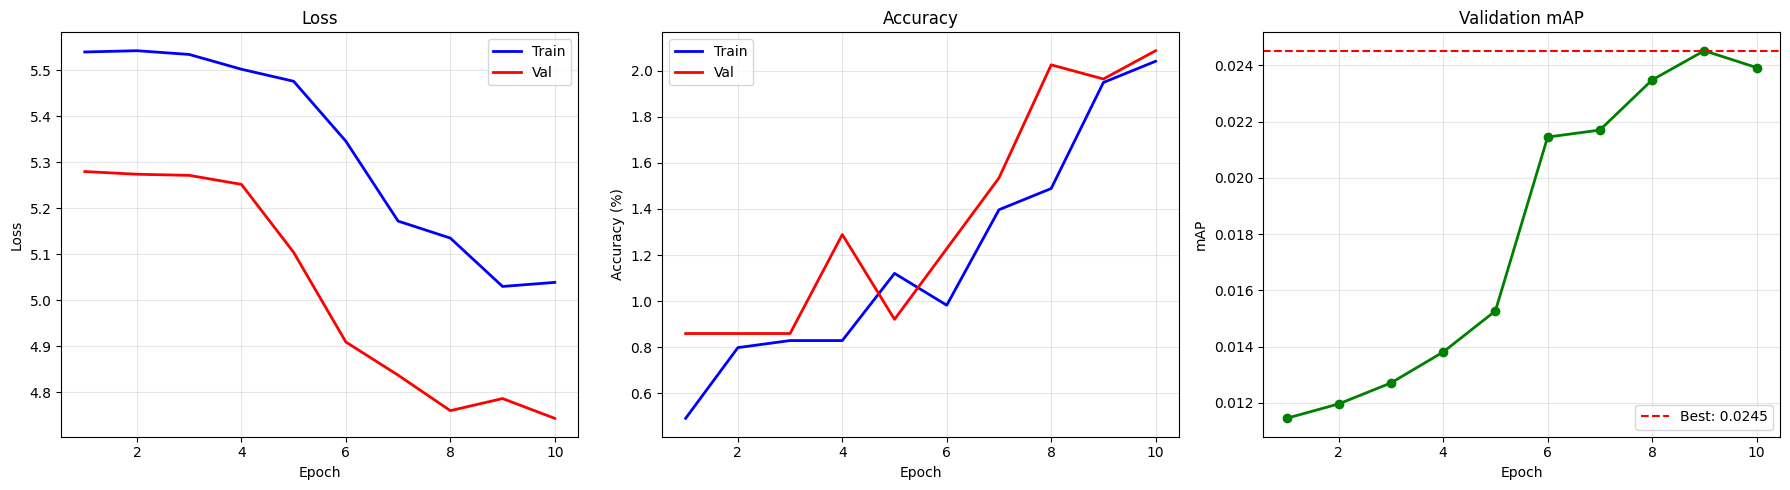

In [36]:
plot_training_history(history)

## Загрузка лучшей модели

In [37]:
checkpoint = torch.load('best_model.pth', map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Загружена модель с эпохи {checkpoint['epoch']+1}")
print(f"mAP: {checkpoint['val_map']:.4f}")
print("\nМетрики:")
for k, v in checkpoint['metrics'].items():
    print(f"  {k}: {v:.4f}")

Загружена модель с эпохи 9
mAP: 0.0245

Метрики:
  precision@1: 0.0252
  precision@5: 0.0179
  recall@1: 0.0035
  recall@5: 0.0121
  mAP: 0.0245


## GradCAM анализ

In [38]:
def get_gradcam_visualization(model, image_tensor, target_class=None):
    model.eval()
    target_layer = model.backbone.conv_head
    cam = GradCAM(model=model, target_layers=[target_layer])
    
    if target_class is None:
        with torch.no_grad():
            _, logits = model(image_tensor, return_logits=True)
            target_class = logits.argmax(dim=1).item()
    
    targets = [ClassifierOutputTarget(target_class)]
    grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
    
    return grayscale_cam[0], target_class


def visualize_gradcam_results(model, dataset, num_samples=6):
    model.eval()
    fig, axes = plt.subplots(3, num_samples, figsize=(18, 8))
    
    indices = random.sample(range(len(dataset)), num_samples)
    
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image_batch = image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            _, logits = model(image_batch, return_logits=True)
            pred = logits.argmax(dim=1).item()
            conf = torch.softmax(logits, dim=1).max().item()
        
        gradcam, _ = get_gradcam_visualization(model, image_batch, pred)
        
        # Денормализация
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        denorm = torch.clamp(image * std + mean, 0, 1)
        rgb_img = denorm.permute(1, 2, 0).numpy()
        
        # Original
        axes[0, i].imshow(rgb_img)
        axes[0, i].set_title(f'GT: {id_to_car[label][:12]}', fontsize=8)
        axes[0, i].axis('off')
        
        # GradCAM
        axes[1, i].imshow(gradcam, cmap='jet')
        axes[1, i].set_title('GradCAM', fontsize=8)
        axes[1, i].axis('off')
        
        # Overlay
        viz = show_cam_on_image(rgb_img, gradcam, use_rgb=True)
        axes[2, i].imshow(viz)
        color = 'green' if pred == label else 'red'
        axes[2, i].set_title(f'Pred: {id_to_car[pred][:12]}\n{conf:.2f}', 
                           fontsize=8, color=color)
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('GradCAM: Original | Heatmap | Overlay', y=1.00)
    plt.show()

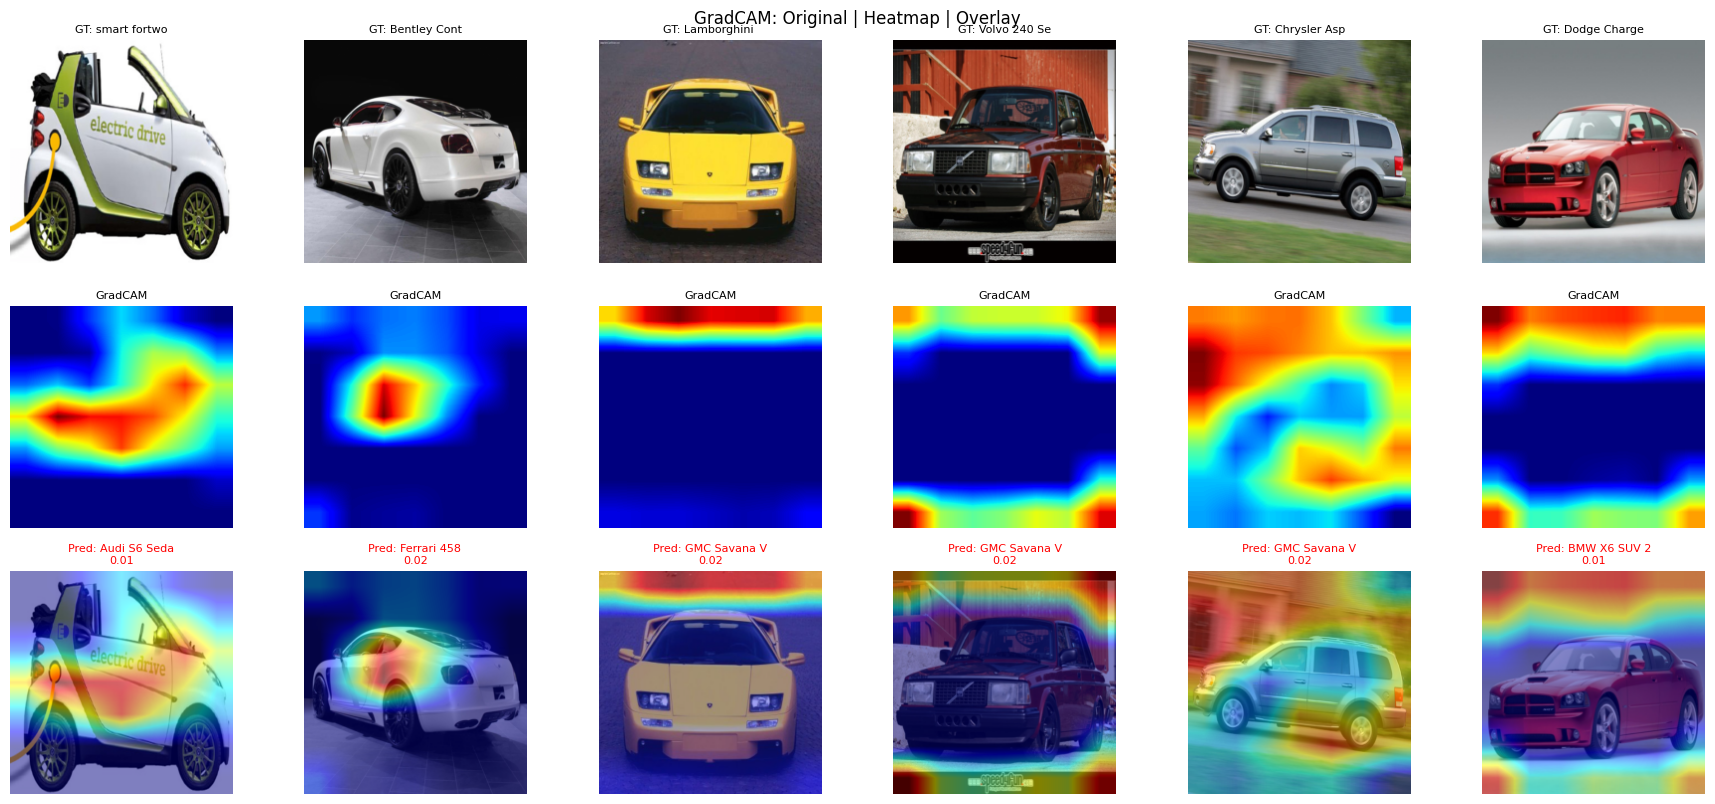

In [39]:
visualize_gradcam_results(model, val_dataset, num_samples=6)

Ужас

## Заполнение итоговой таблицы

In [40]:
results_summary = {
    "Конфигурация": ["EfficientNet-B0 + Triplet Loss"],
    "Precision@1": [checkpoint['metrics']['precision@1']],
    "Precision@5": [checkpoint['metrics']['precision@5']],
    "Recall@1": [checkpoint['metrics']['recall@1']],
    "Recall@5": [checkpoint['metrics']['recall@5']],
    "mAP": [checkpoint['metrics']['mAP']],
    "Val Accuracy": [history['val_accs'][-1]],
}

In [41]:
df = pd.DataFrame(results_summary)
print("\n" + "="*80)
print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ")
print("="*80)
print(df.to_string(index=False))
print("="*80)



ИТОГОВЫЕ РЕЗУЛЬТАТЫ
                  Конфигурация  Precision@1  Precision@5  Recall@1  Recall@5      mAP  Val Accuracy
EfficientNet-B0 + Triplet Loss     0.025169     0.017925  0.003467  0.012146 0.024518       2.08717


# А выводы пока такие, что модель не учится